# Network Analysis
## Author: Wing Yan Sang

## Date: 11/30/2017

<p><a name="sections"></a></p>


## Sections
- <a href="#pre-processing"> Pre-Processing</a><br>
- <a href="#graphs"> Network Graphs</a><br>
- <a href="#centrality"> Centrality</a><br>
 - <a href="#centrality1">Centrality Analysis 1: "Celebrities"</a><br>
 - <a href="#centrality2">Centrality Analysis 2: "Gossipmongers"</a><br>
 - <a href="#centrality3">Centrality Analysis 3: "Boundary Spanners"</a><br>
 - <a href="#centrality4">Centrality Analysis 4: "Gray Cardinals"</a><br>
 - <a href="#centrality5">Centrality Analysis 5: "Page Rank"</a><br>   
 - <a href="#centrality_summary">Centrality Analysis: Summary </a><br>   
- <a href="#ccc"> Cliques, Clusters, Components</a><br>

In [1]:
#import mysql.connector
import pandas as pd
import numpy as np
import mysql.connector as sql
import breakinghits_script as bh

from matplotlib import pyplot as plt
import networkx as nx
%matplotlib inline

pd.options.display.max_rows = 1000

<p><a name="pre-processing"></a></p>
## Pre-Processing

In [2]:
def get_table(table_name, col_names):    
    # This function pulls specified data from Breaking Hits MySQL server
    # parameters: 'table_name' as string, 'col_names' as list of strings
    cnx = sql.connect(user='breaking_read',
                                  password='(hHy;gTPMnet',
                                  host='206.225.82.147',
                                  database='breaking_livedb')
    cur = cnx.cursor()
    select_statement = 'SELECT ' + ', '.join(col_names) + ' FROM ' + table_name +';'
    cur.execute(select_statement)
    rows = cur.fetchall()                         # get all selected rows
    field_names = [i[0] for i in cur.description] # get all column names
    cnx.close() # close the sql connection

    table = pd.DataFrame(rows, columns=field_names)
    return(table)

In [3]:
#Define function that removes rows with missing data 
def dropMissing(df):
    df = df.replace('', np.nan, regex=True) #convert empty cells to nan
    df = df.dropna()
    return df


In [4]:
#Define function that converts object to int64 for each data frame. (assumes no missing values)
def convertInt(df):
    for col in df.columns:
        if (df[col].dtype == 'object'):
            df[col] = df[col].astype(int)
    return df


In [5]:
#Define function that returns 1) formatted data frame and 2)connected graph object based on the type of connection 
#between nodes. Inputs are 1: Connection Type(follow, message, view, or sociallink)

def get_graph(connection='follow'):
    
    if (connection == 'sociallink'):
        df = get_table('bh_social_link_activity', ['user_id_shared', 'user', 'date_shared'])
    elif (connection == 'message'):
        df = get_table('bh_messenger', ['sendfrom', 'sendto', 'u_read', 'data_added'])
    elif (connection == 'view'):
        df = get_table('bh_music_views', ['artists_id', 'user_id', 'date_added'])
    else:
        df = get_table('user_following', ['followed_id', 'follower_id', 'date_followed'])
    
    
    #Drop missing rows and convert and convert object to int for each column:   
    df = dropMissing(df)
    df = convertInt(df)
    
    #Create graph object and draw edges between nodes
    G = nx.Graph()
    for row in df.itertuples():
        if (connection == 'message'):
            G.add_edge(row[1], row[2], read= row[3], date=row[4])
        else:
            G.add_edge(row[1], row[2], date=row[3])
    
    return df, G

In [6]:
#examine missingness of the various dataframes:
connection = ['follow', 'message', 'view', 'sociallink']
[print(bh.countMissing(get_graph(i)[0]),'\n') for i in connection]


               Count  Percentage
followed_id        0         0.0
follower_id        0         0.0
date_followed      0         0.0 

            Count  Percentage
sendfrom        0         0.0
sendto          0         0.0
u_read          0         0.0
data_added      0         0.0 

            Count  Percentage
artists_id      0         0.0
user_id         0         0.0
date_added      0         0.0 

                Count  Percentage
user_id_shared      0         0.0
user                0         0.0
date_shared         0         0.0 



[None, None, None, None]

In [7]:
#examine column types for each data frame

connection = ['follow', 'message', 'view', 'sociallink']

for i in connection:
    print(i, " dataframe", '\n')
    print(get_graph(i)[0].dtypes)

follow  dataframe 

followed_id               int64
follower_id               int64
date_followed    datetime64[ns]
dtype: object
message  dataframe 

sendfrom               int64
sendto                 int64
u_read                 int64
data_added    datetime64[ns]
dtype: object
view  dataframe 

artists_id             int64
user_id                int64
date_added    datetime64[ns]
dtype: object
sociallink  dataframe 

user_id_shared             int64
user                       int64
date_shared       datetime64[ns]
dtype: object


<p><a name="graphs"></a></p>
## Network Graphs

-- View Follow/Followed network 

-- Define function to filter graph to only include users tagged critics/artists and to add attribute artist/critic

In [58]:
#call function to get graph and data frame for follow/followed connection type
df_follow, g = get_graph('follow')
listeners, artists = bh.users()

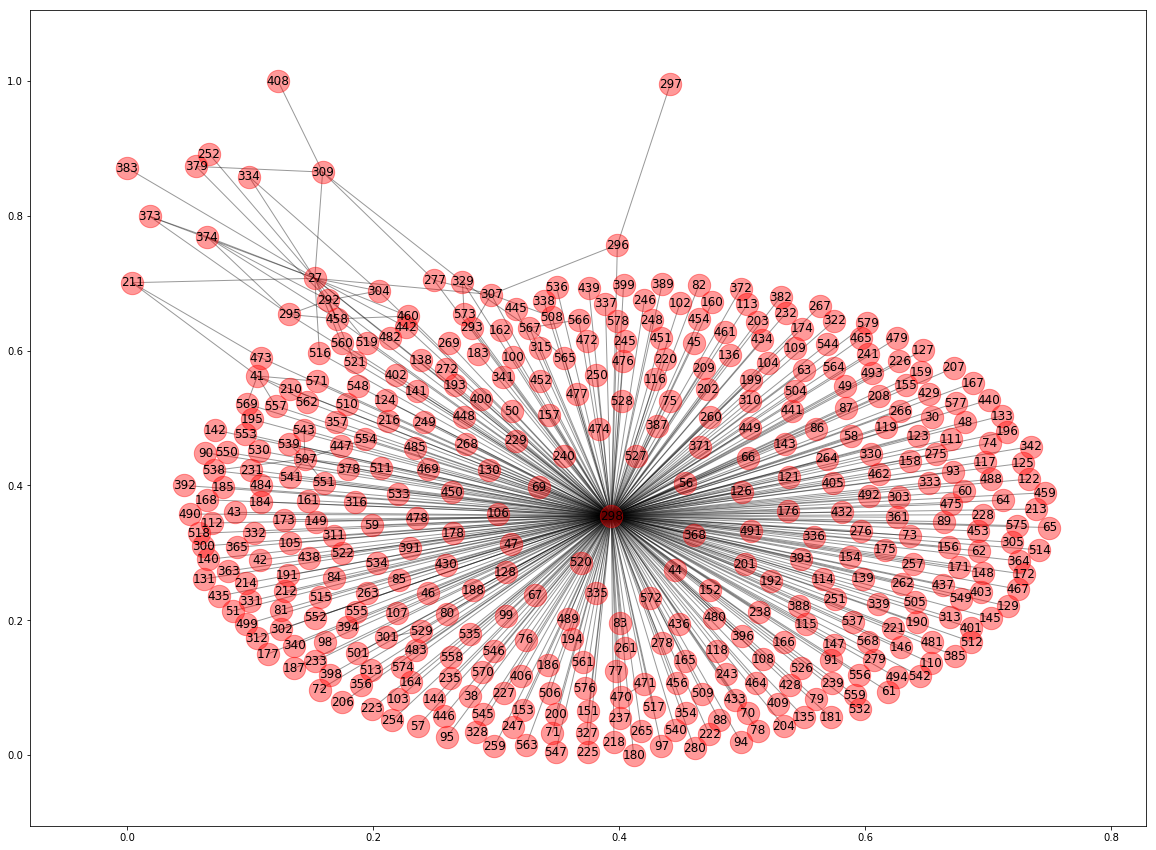

In [9]:
#plot of network, whether tagged or not as listener/artist
plt.figure(figsize=(20,15))
nx.draw_networkx(g, node_size = 500, alpha = 0.4)

In [10]:
#Define function to filter graph object to only include those that are tagged as critic/artist and label
#nodes as critic/artist
def filter_graph(g):
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())] #list of artists
    s1 = l_list + a_list #combined list of critics and artists 
    s2 = list(set(s1) & set(g.nodes())) #list of people in g.nodes() and tagged as artist or critic
    
    g_reduced = nx.Graph(g.subgraph(s2))
    
    
    # define node attribute 'user_type' = artist or critic
    key_list = g_reduced.nodes()
    for i in range(0,len(key_list)): 
        if (key_list[i] in l_list):
            g_reduced.node[key_list[i]]['user_type'] = 'critic'
        else:
            g_reduced.node[key_list[i]]['user_type'] = 'artist'
    
    return g_reduced

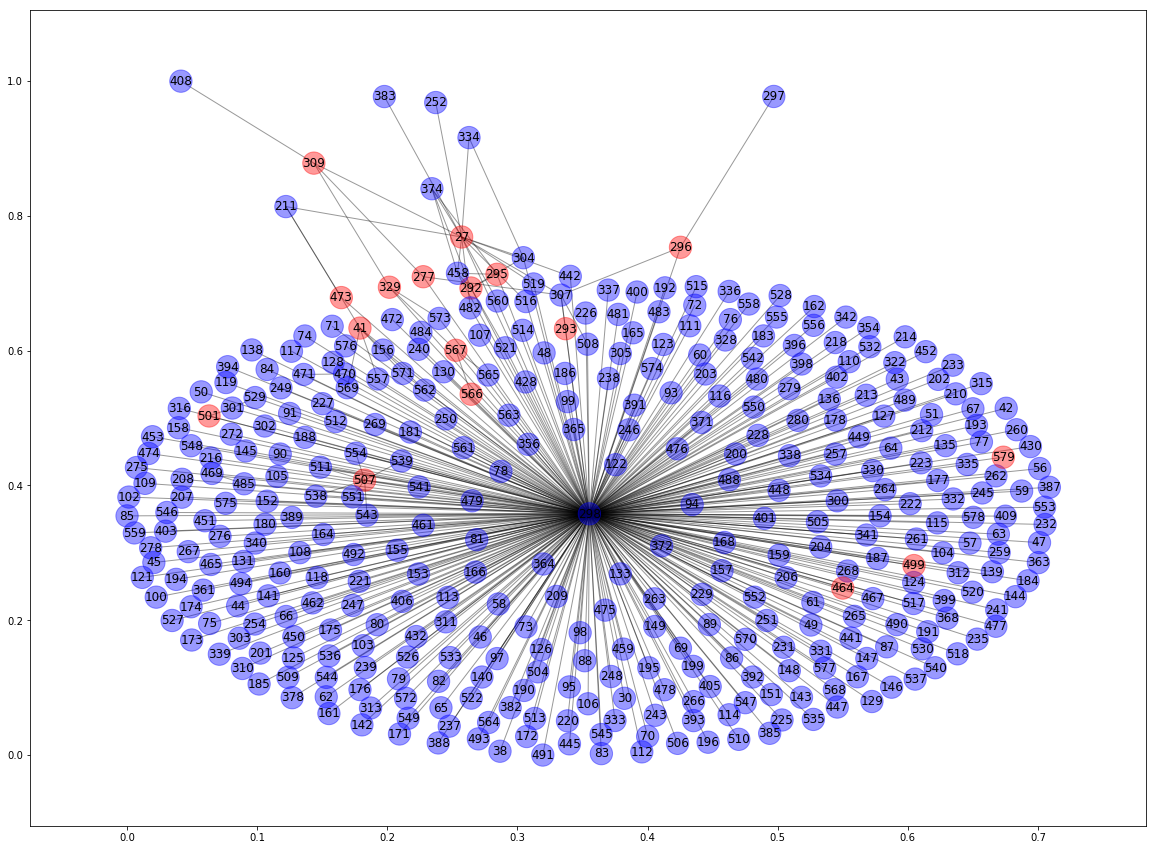

In [11]:
#implement filter function and draw the filtered graph
g_reduced = filter_graph(g)
color_map = {}
key_list = g_reduced.nodes()

for i in range(0, len(key_list)):
    if(g_reduced.node[key_list[i]]['user_type'] == 'critic'):
        color_map[key_list[i]] = 'b'
    else:
        color_map[key_list[i]] = 'r'

colors = [color_map.get(node) for node in g_reduced.nodes()]
plt.figure(figsize=(20,15))
nx.draw_networkx(g_reduced, node_color = colors, node_size = 500, alpha = 0.4)

<p><a name="centrality1"></a></p>
## Centrality Analysis #1: "Celebrities"

In [12]:
import operator

#defines a function that returns a sorted list of people (1st element) and the number of connections (2nd element)
def sorted_map(map):
    sorted_map = sorted(map.items(), key=operator.itemgetter(1), reverse = True) 
    return(sorted_map)


In [56]:
#Define a function that returns top n "celebrities" in form of data frame

def getCeleb(g, n, user_type =None):
    d=nx.degree(g) 
    ds=sorted_map(d)
    ds_critic = []
    ds_artist = []
    
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())] 
    
    for i in range(0,len(ds)):
        if (ds[i][0] in l_list):
            ds_critic.append(ds[i])
        else:
            ds_artist.append(ds[i])
    
    if (user_type == 'critic'):
        temp = ds_critic
    elif (user_type == 'artist'):
        temp = ds_artist[0:n]
    else:
        temp = ds[0:n]
    
    import heapq
    b = [x[1] for x in temp]
    b_n = min(heapq.nlargest(n, set(b)))
    ans = [x for x in temp if x[1]>=b_n]  
    
    return(pd.DataFrame(ans, columns = ["id", "num_connections"]))




In [78]:
#Test function
n = 5
user_type = 'critic'
print("Top %d %ss by number of connections (%s, #connections):" %(n,user_type, user_type))
temp = getCeleb(g_reduced, n, user_type = 'critic')
temp

Top 5 critics by number of connections (critic, #connections):


,id,num_connections
0,298,381
1,307,6
2,458,5
3,304,4
4,374,4
5,211,3
6,301,3


In [94]:
temp[temp['id'] == 374].index.values[0]+1

4

<p><a name="centrality2"></a></p>
## Centrality Analysis #2: "Gossipmongers"

In [15]:
#Function that returns top n "gossipmongers" by critic/artist in form of data frame

def getClose(g, n, user_type =None):
    c = nx.closeness_centrality(g)
    cs=sorted_map(c)
    cs_critic = []
    cs_artist = []
    
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())] 
    
    for i in range(0,len(cs)):
        if (cs[i][0] in l_list):
            cs_critic.append(cs[i])
        else:
            cs_artist.append(cs[i])
    
    if (user_type == 'critic'):
        ans = cs_critic[0:n]
    elif (user_type == 'artist'):
        ans = cs_artist[0:n]
    else:
        ans =cs[0:n]
    return(pd.DataFrame(ans, columns = ["id", "closeness"]))


In [16]:
#Test function
n = 5
user_type = 'critic'
print("Top %d %ss by closeness measure (%s, closeness):" %(n,user_type, user_type))
getClose(g_reduced, n, user_type)

Top 5 critics by closeness measure (critic, closeness):


,id,closeness
0,298,0.977387
1,307,0.503234
2,458,0.501935
3,304,0.501289
4,442,0.500000


<p><a name="centrality3"></a></p>
## Centrality Analysis #3: "Boundary Spanners"

In [17]:
#Function that returns top n "boundary spanners" by critic/artist

def getSpan(g, n, user_type=None):
    b = nx.betweenness_centrality(g)
    bs=sorted_map(b)
    bs_critic = []
    bs_artist = []
    
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())]
    
    for i in range(0,len(bs)):
        if (bs[i][0] in l_list):
            bs_critic.append(bs[i])
        else:
            bs_artist.append(bs[i])
    
    if (user_type == 'critic'):
        ans = bs_critic[0:n]
    elif (user_type == 'artist'):
        ans = bs_artist[0:n]
    else:
        ans = bs[0:n]
    return(pd.DataFrame(ans, columns = ["id", "betwenness"]))


In [18]:
#Test function
n = 5
user_type = "critic"
print("Top %d %ss by betweenness measure (%s_id, betweenness):" %(n,user_type, user_type))
getSpan(g_reduced, n, user_type)

Top 5 critics by betweenness measure (critic_id, betweenness):


,id,betwenness
0,298,0.997224
1,304,0.002483
2,458,0.001264
3,307,0.000244
4,211,0.000074


<p><a name="centrality4"></a></p>
## Centrality Analysis #4: "Gray Cardinals"

In [19]:
#calculate eigenvalues
e = nx.eigenvector_centrality_numpy(g_reduced)
es = sorted_map(e)
es

#check the eigenvalues are greater than 0 
#(https://stackoverflow.com/questions/43208737/using-networkx-to-calculate-eigenvector-centrality)
es[-1][1]>0

# define function that returns top n people by eigenvalue
def getEigen(g, n, user_type =None):
    e = nx.eigenvector_centrality_numpy(g)
    es = sorted_map(e)
    
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())]
    
    if (es[-1][1]>0):
        es_critic = []
        es_artist = []
        
        for i in range(0,len(es)):
            if (es[i][0] in l_list):
                es_critic.append(es[i])
            else:
                es_artist.append(es[i])
                
        if (user_type == 'critic'):
            ans = es_critic[0:n]
        elif (user_type == 'artist'):
            ans = es_artist[0:n]
        else:
            ans =es[0:n]
        
        return(pd.DataFrame(ans, columns = ["id", "eigenvalue"]))
    else:
        return("No maximum eigenvalue found.")
        

In [20]:
#Test function
n = 5
user_type = 'critic'
print("Top %d %ss by eigenvalue (%s, eigenvalue):" %(n,user_type, user_type))
getEigen(g_reduced, n, user_type)

Top 5 critics by eigenvalue (critic, eigenvalue):


,id,eigenvalue
0,298,0.704566
1,307,0.046453
2,458,0.043470
3,304,0.041162
4,301,0.039745


<p><a name="centrality5"></a></p>
## Centrality Analysis #5: Page Rank

In [21]:
#Function that returns top n "boundary spanners" by critic/artist

def getPgRank(g, n, user_type=None):
    p = nx.pagerank(g)
    ps=sorted_map(p)
    ps_critic = []
    ps_artist = []
    
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())]
    
    for i in range(0,len(ps)):
        if (ps[i][0] in l_list):
            ps_critic.append(ps[i])
        else:
            ps_artist.append(ps[i])
    
    if (user_type == 'critic'):
        ans = ps_critic[0:n]
    elif (user_type == 'artist'):
        ans = ps_artist[0:n]
    else:
        ans = ps[0:n]
    return(pd.DataFrame(ans, columns = ["id", "page_rank"]))


In [22]:
#Test function
n = 5
user_type = "critic"
print("Top %d %ss by PageRank (%s, page_rank):" %(n,user_type, user_type))
getPgRank(g_reduced, n, user_type)

Top 5 critics by PageRank (critic, page_rank):


,id,page_rank
0,298,0.413613
1,307,0.005535
2,458,0.004175
3,304,0.003546
4,374,0.003267


<p><a name="centrality_summary"></a></p>
## Centrality Analysis: Summary

-- Define function that returns top users for all centrality measures

-- Define function that returns centrality measures for specific user

In [26]:
#function that returns top n for each of the previous centrality measures in a data frame and sorts by
#number of connections
def topCentral(g, n, user_type):
    df_celeb = getCeleb(g, n, user_type)
    df_close = getClose(g, n, user_type)
    df_span = getSpan(g, n, user_type)
    df_eigen = getEigen(g, n, user_type)
    df_rank = getPgRank(g, n, user_type)
    
    names1 = df_celeb['id']
    names2 = df_close['id']
    names3 = df_span['id']
    
    if(type(df_eigen) == pd.DataFrame):
        names4 = df_eigen['id']
    else:
        names4 = names1
    names5 = df_rank['id']
    names=list(set(names1) | set(names2) | set (names3) | set (names4) | set (names5))
    
    df_celeb2 = getCeleb(g, len(g), user_type)
    df_close2 = getClose(g, len(g), user_type)
    df_span2 = getSpan(g, len(g), user_type)
    df_eigen2 = getEigen(g, len(g), user_type)
    df_rank2 = getPgRank(g, len(g), user_type)
    
    if(type(df_eigen) == pd.DataFrame):    
        table = [[name,df_celeb2.iloc[df_celeb2[df_celeb2['id']==name].index.values.astype(int)[0],1], \
            df_close2.iloc[df_close2[df_close2['id']==name].index.values.astype(int)[0],1], \
            df_span2.iloc[df_span2[df_span2['id']==name].index.values.astype(int)[0],1], \
            df_eigen2.iloc[df_eigen2[df_eigen2['id']==name].index.values.astype(int)[0],1],\
            df_rank2.iloc[df_rank2[df_rank2['id']==name].index.values.astype(int)[0],1]] for name in names] 
    
    else:
        table = [[name,df_celeb2.iloc[df_celeb2[df_celeb2['id']==name].index.values.astype(int)[0],1], \
            df_close2.iloc[df_close2[df_close2['id']==name].index.values.astype(int)[0],1], \
            df_span2.iloc[df_span2[df_span2['id']==name].index.values.astype(int)[0],1], \
            np.nan, df_rank2.iloc[df_rank2[df_rank2['id']==name].index.values.astype(int)[0],1]]
            for name in names] 
    df = pd.DataFrame(table[1:],columns= ['id',df_celeb.columns.get_values()[1], 
                      df_close.columns.get_values()[1], df_span.columns.get_values()[1],
                      "eigenvalue", df_rank.columns.get_values()[1]])
    
    df = df.sort_values(df_celeb.columns.get_values()[1], ascending = False)
    return(df)

In [28]:
#Test getCentral function by iterating it through the various connection types

#Arguments passed to function
n = 3
user_type = 'critic'
connection = ['follow', 'message', 'view', 'sociallink']

for i in connection:
    g = get_graph(i)[1]
    g_reduced = filter_graph(g)
    print(i, " connection type", '\n')
    print("Summary of top %ss by various centrality measures, sorted by number of connections:" %( user_type),'\n')
    print(topCentral(g_reduced, n, user_type), '\n')

follow  connection type 

Summary of top critics by various centrality measures, sorted by number of connections: 

    id  num_connections  closeness  betwenness  eigenvalue  page_rank
2  298              381   0.977387    0.997224    0.704566   0.413613
0  307                6   0.503234    0.000244    0.046453   0.005535
1  458                5   0.501935    0.001264    0.043470   0.004175 

message  connection type 

Summary of top critics by various centrality measures, sorted by number of connections: 

     id  num_connections  closeness  betwenness  eigenvalue  page_rank
9   298               18   0.675000    0.708429         NaN   0.228550
0   514                2   0.066667    0.002299         NaN   0.047084
2   451                2   0.411864    0.000000         NaN   0.025419
6   458                2   0.405000    0.059770         NaN   0.030911
1   322                2   0.307595    0.001149         NaN   0.025551
12  557                1   0.303750    0.000000         NaN

In [99]:
#Define function that returns 1) data frame with the various centrality measures for a given user 
# and 2) second data frame with ranks 

def getCentral (user):
    connection = ['follow', 'message', 'view', 'sociallink']
    table1 =[] #table for centrality measures
    table2 =[] #table for centrality ranks
    
    for i in connection:
        g = get_graph(i)[1]
        g = filter_graph(g)
        
        #code for data frame with centrality measures
        d = nx.degree(g)[user]
        c = nx.closeness_centrality(g)[user]
        b = nx.betweenness_centrality(g)[user]
        p = nx.pagerank(g)[user]
        
        e = nx.eigenvector_centrality_numpy(g)
        es = sorted_map(e)
        
        if (es[-1][1]>0):
            e = nx.eigenvector_centrality_numpy(g)[user]
        else:
            e =np.nan
        
        table1.append([i,d, c, b, e, p])
        
        #code for data frame with centrality ranks
        max_ = len(g.nodes())
        df = getCeleb(g, max_)
        d_rank = df[df['id'] == user].index.values[0]+1
        df = getClose(g, max_)
        c_rank = df[df['id'] == user].index.values[0]+1
        df = getSpan(g, max_)
        b_rank = df[df['id'] == user].index.values[0]+1
        df = getPgRank(g, max_)
        p_rank = df[df['id'] == user].index.values[0]+1
        
        df = getEigen(g, max_)
        if (type(df) == pd.DataFrame):
            e_rank = df[df['id'] == user].index.values[0]+1
        else:
            e_rank =np.nan
            
        table2.append([i,d_rank, c_rank, b_rank, e_rank, p_rank])
     
    df1 = pd.DataFrame(table1, columns = ['connection_type', 'num_connections', 'closeness', 'betweenness', 
                                        'eigenvalue',  'page_rank'])
        
    df1.set_index('connection_type')
    
    df2 = pd.DataFrame(table2, columns = ['connection_type', 'num_connections', 'closeness', 'betweenness', 
                                        'eigenvalue',  'page_rank'])
        
    df2.set_index('connection_type')
    
        
    return df1, df2

In [100]:
#Test getCentral function
getCentral(27)

(  connection_type  num_connections  closeness  betweenness  eigenvalue  \
 0          follow               15   0.509162     0.019735    0.054096   
 1         message                7   0.467308     0.124904         NaN   
 2            view              119   0.796954     0.104710    0.238463   
 3      sociallink                2   0.293878     0.120879         NaN   
 
    page_rank  
 0   0.012857  
 1   0.080604  
 2   0.044426  
 3   0.070542  ,
   connection_type  num_connections  closeness  betweenness  eigenvalue  \
 0          follow                2          2            2         2.0   
 1         message                2          2            3         2.0   
 2            view                1          1            4         1.0   
 3      sociallink                7          9            4         NaN   
 
    page_rank  
 0          2  
 1          2  
 2          3  
 3          6  )

<p><a name="ccc"></a></p>
## Components and Subgraphs

#### Subcomponents

In [101]:
## define function that returns the top n components (graphs objects) by number of nodes
## this can possibly be fed into a pipeline for further analysis of the components
def getComponent(g, n):
    graphs = sorted(nx.connected_component_subgraphs(g), key = len, reverse=True)
    n_nodes = [nx.number_of_nodes(g) for g in graphs]
    
    if (n>len(graphs)):
        return("Number entered exceeds max value of %d. Please try again" %(len(graphs)))
    else:
        import heapq
        min_= min(heapq.nlargest(n, set(n_nodes)))        
        ans = [g for g in graphs if nx.number_of_nodes(g) >=min_]
        return(ans)

In [102]:
##Test function
e=nx.read_pajek("egypt_retweets.net")
graphs = sorted(nx.connected_component_subgraphs(e),key = len, reverse=True)
n_nodes = [nx.number_of_nodes(g) for g in graphs]
getComponent(e, 5)

#### Islands

In [104]:
#Define function that removes edges with weights below a certain level and returns graph object
def trim_edges(g, weight=1): 
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if (edata['weight']) > weight:
            g2.add_edge(f,to,edata)
        return g2

In [105]:
#Define a function to gradually trim the network into smaller networks. Returns threshold value and graph object.
#This can possibly be fed into a pipeline for further analysis of the islands.
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step=int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [106]:
#test island_method function on biggest component from Egyptian Revolution retweets example:
cc=getComponent(e,5)[0]
islands=island_method(cc)
islands

[[1, <networkx.classes.graph.Graph at 0x11948e9e8>],
 [62, <networkx.classes.graph.Graph at 0x11948e048>],
 [123, <networkx.classes.graph.Graph at 0x11948ee80>],
 [184, <networkx.classes.graph.Graph at 0x11948e208>],
 [245, <networkx.classes.graph.Graph at 0x11948eac8>]]

#### Ego graphs and networks

In [107]:
#Define function that returns ego graph object for given user, connection type, depth of search

def getEgo (user, connection, depth):
    g = get_graph(connection)[1]
    g = filter_graph(g)
    ego = nx.Graph(nx.ego_graph(g,user, radius=depth))
    return ego

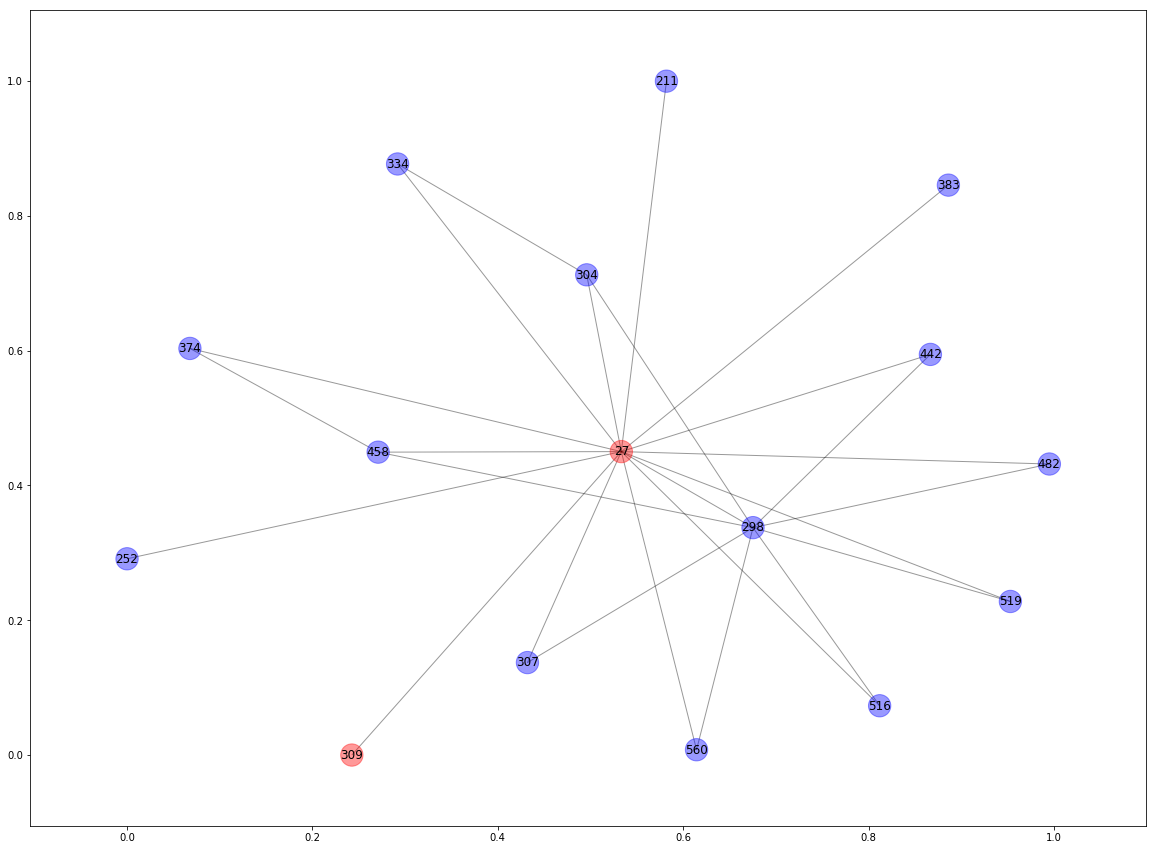

In [109]:
#Test getEgo function
#Draw ego graph

user = getEgo(27, 'follow', 1)

color_map = {}
key_list = user.nodes()

for i in range(0, len(key_list)):
    if(user.node[key_list[i]]['user_type'] == 'critic'):
        color_map[key_list[i]] = 'b'
    else:
        color_map[key_list[i]] = 'r'

        
colors = [color_map.get(node) for node in user.nodes()]

plt.figure(figsize=(20,15))
nx.draw_networkx(user, node_color = colors, node_size = 500, alpha = 0.4)

#print(len(user), ";", nx.average_clustering(user))

In [110]:
#Explore other attributes of ego graph object:
print("Number of connections is:", len(user), '\n')
print("Average clustering is:", nx.average_clustering(user))


Number of connections is: 16 

Average clustering is: 0.6031746031746031


#### Triads

drawing nodes...
{'None': 'r', '93_Penn': 'g', '11_WTC North': 'b', '175_WTC South': 'm', '77_Pentagon': 'c'}
drawing edges...
drawing labels...


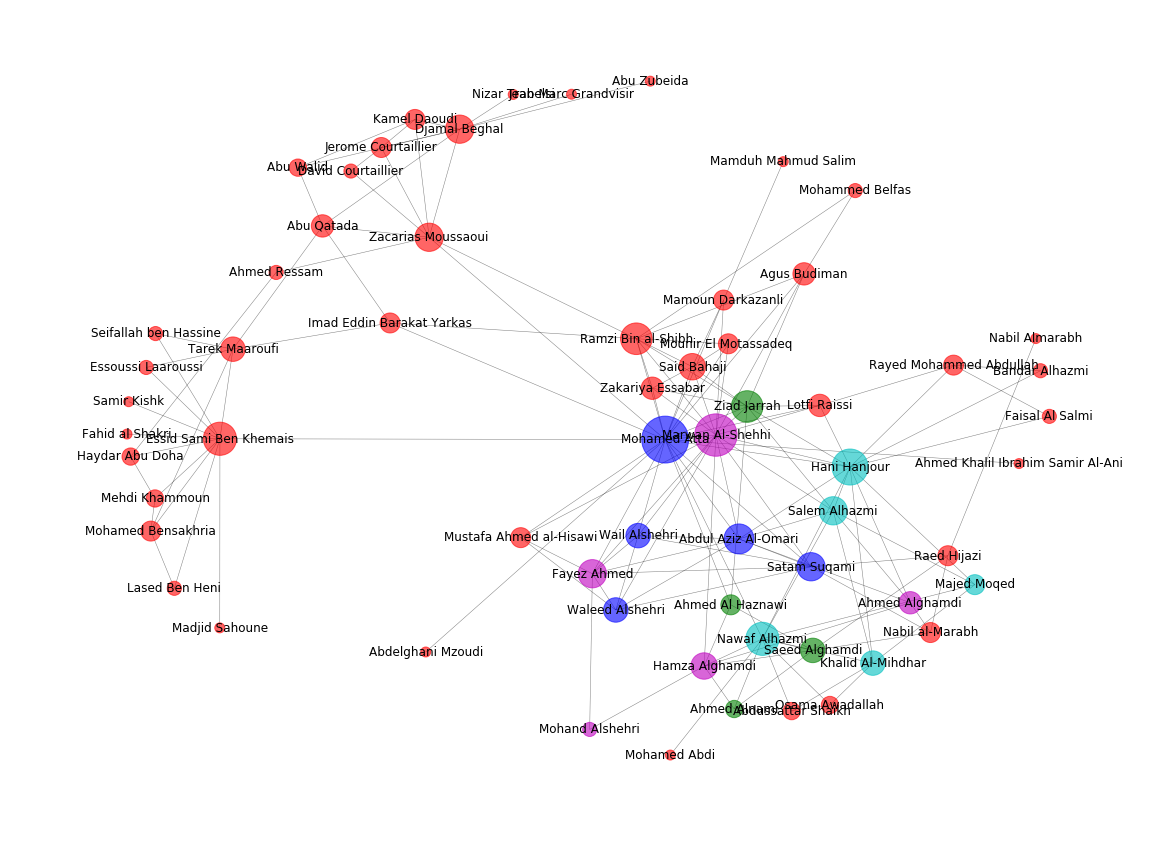

In [111]:
#9/11 example from Book. Columns in the "edgelist.text" file, in order, are: 
#1)from, 2) to, 3) strength of tie, 4) level to which tie has been confirmed
#"attrib.txt" file contains the flight each person was on.

import csv 

with open('9_11_edgelist.txt', 'r') as f:
    reader = csv.reader(f) 
    g = nx.Graph()
    for row in reader:
        g.add_edge(row[0],row[1],weight=row[2],conf=row[3])
    
    for n in g.nodes_iter(): 
        g.node[n]['flight']='None'

with open('9_11_attrib.txt', 'r') as f:
    attribute = csv.reader(f) 
    for row in attribute:
        g.node[row[0]]['flight']=row[1]

##Examine largest subcomponent
components=sorted(nx.connected_component_subgraphs(g), key = len, reverse=True)
cc = components[0]

#Plot largest subcomponent. The function reads node attributes and assigns colors to 
#them based on attribute values. "multimode" function is defined in multimode.py file.

from collections import defaultdict
import multimode as mm

plt.figure(figsize=(20,15))
mm.plot_multimode(cc,type_string='flight')


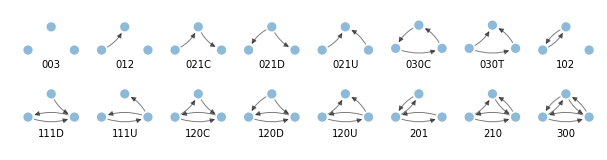

{'003': 22.0,
 '012': 0,
 '021C': 0,
 '021D': 0,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 63,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 24,
 '210': 0,
 '300': 11}

In [112]:
#Census of triad types using sample data. First number is number of bidirectional edges. 
#Second number is number of single edges. Third number is number of non-existent edges.
import triadic
import draw_triads
g=nx.DiGraph(nx.krackhardt_kite_graph())

census, node_census = triadic.triadic_census(g) 
census

In [113]:
#Census of triad types using BH data.

g = get_graph('follow')[1]
g2 = nx.DiGraph(nx.krackhardt_kite_graph())
census, node_census = triadic.triadic_census(g2) 
census

{'003': 22.0,
 '012': 0,
 '021C': 0,
 '021D': 0,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 63,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 24,
 '210': 0,
 '300': 11}

In [115]:
#Generate table of nodes with number of instances in each of the triad types

keys=node_census[0].keys()
## Generate a table header
print ('| Node |', ' | '.join(keys))
## Generate table contents
## A little magic is required to convert ints to strings 
for k in node_census.keys():
    print ('|', k, '|',' | '.join([str(v) for v in node_census[k].values()]))

| Node | 003 | 210 | 201 | 300 | 111U | 120U | 021C | 111D | 021U | 021D | 012 | 120C | 030C | 030T | 120D | 102
| 0 | 0 | 0 | 8 | 4 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 14
| 1 | 0 | 0 | 4 | 3 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 11
| 2 | 0 | 0 | 4 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 7
| 3 | 0 | 0 | 3 | 2 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 7
| 4 | 0 | 0 | 2 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 4
| 5 | 0 | 0 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 5
| 6 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 3
| 7 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 5
| 8 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 7
| 9 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0


In [136]:
#See which users are in the most closed triads, i.e., cliques. First column is user, second is triads.
#Define function that returns count of closed triads each user is in by type of connection (follow, message)


def getCensus(connection, n, user_type = None):
    g = get_graph(connection)[1]
    g = filter_graph(g)
    
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())]
        
    census, node_census = triadic.triadic_census(g)
    
    if user_type =='critic':
        user_list = list(set(node_census.keys()) & set(l_list))
    elif user_type == 'artist':
        user_list = list(set(node_census.keys()) & set(a_list))
    else:
        user_list = node_census.keys()
    closed_triads=[[v,-k] for k,v in sorted([[-node_census[k]['300'],k] for k in user_list])]
    closed_triads_df = pd.DataFrame(closed_triads, columns = ['id', 'closed_triads'])
    return(closed_triads_df[0:n])

In [138]:
#Test code
getCensus('follow', 5, 'critic')

,id,closed_triads
0,298,16
1,30,0
2,38,0
3,42,0
4,43,0


#### Hierarchical Clustering

In [175]:
import hc

eco=nx.read_pajek("economic.net")
hc.create_hc(eco, 0)

[['Nagorni Karabakh', 'Armenia'],
 ['Turkmenistan', 'EU'],
 ['South Osetia'],
 ['USA', 'Kazakhstan'],
 ['Georgia', 'Russia'],
 ['Azerbajan', 'Turkey'],
 ['Abkhazia', 'Iran'],
 ['Chechnya']]

In [ ]:
plt.figure(figsize = (15, 12))
nx.draw_networkx()